# Goal

Shift  each MNIST image in any direction (left, right, up, down) by one pixel, and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe an increase in performance!

This technique of artificially growing your training dataset is called `data augmentation` or `training set expansion`.

Hint: to shift the images, you can use the `shift` function from the `scipy.ndimage.interpolation` module.

For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right.

# Load the data

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
def train_test_split(X, y, test_prop=.3):
    train_size = round(len(X) * (1-test_prop))
    train_slice = slice(train_size)
    test_slice = slice(train_size, None)
    return X[train_slice], X[test_slice], y[train_slice], y[test_slice]

In [39]:
X  = mnist["data"].values
y = mnist["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Play with the shift function

In [5]:
from scipy.ndimage import shift

In [7]:
sample_digit = X_train[0]
sample_digit_2d = sample_digit.reshape(28, 28)

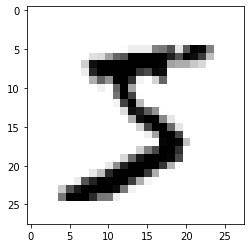

In [18]:
import matplotlib.pyplot as plt
plt.imshow(sample_digit_2d, cmap="binary")

Let's shift this image 5 pixels up and 10 to the right,

In [21]:
shifted_sample_digit_2d = shift(sample_digit_2d, shift=[-5, 10])

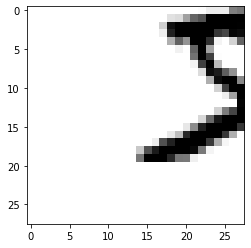

In [22]:
plt.imshow(shifted_sample_digit_2d, cmap="binary")

In [57]:
X_train.shape

(49000, 784)

# Augment the data

In [50]:
import numpy as np
from typing import Generic, TypeVar, Tuple

Shape = TypeVar("Shape")
DType = TypeVar("DType")

class Array(np.ndarray, Generic[Shape, DType]):
    ...

In [62]:
def shift_image(img: Array['N,1', float], shift_px: Tuple[int, int]) -> Array['N,1', float]:
    img = img.copy()
    n_pixels = len(img)
    side_len = int(np.sqrt(n_pixels))
    img_2d = img.reshape(side_len, side_len)
    shifted_img_2d = shift(img_2d, shift_px)
    return shifted_img_2d.reshape([n_pixels])
    

In [65]:
def augment_data(X_train, y_train, pixel_shifts=None):
    new_X = X_train.copy()
    new_y = y_train.copy()
    # 1 right, left, down, up
    pixel_shifts = pixel_shifts or ((0, 1), (0, -1), (1, 0), (0, 1))
    for pixel_shift in pixel_shifts:
        shifted_X = np.apply_along_axis(shift_image, 1, X_train, pixel_shift)
        new_X = np.concatenate([new_X, shifted_X])
        new_y = np.concatenate([new_y, y_train])
    return new_X, new_y

In [66]:
aug_X_train, aug_y_train = augment_data(X_train, y_train)

In [67]:
len(X_train), len(aug_X_train)

(49000, 245000)

# Train and evaluate the model

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
kn = KNeighborsClassifier()

In [70]:
kn.fit(aug_X_train, aug_y_train)

KNeighborsClassifier()

In [71]:
y_pred = kn.predict(X_test)

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
accuracy_score(y_test, y_pred)

0.9722857142857143

Already over 97 %! :)